## Preprocess before merge

In [1]:
import sys
import os
import re
sys.path.append('../')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import time
sns.set()
pd.set_option('display.max_columns', None)
pd.option_context("display.max_rows", None)
pd.set_option('precision', 2)
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from utils import *
import altair as alt
from altair import datum

In [2]:
uw = pd.read_excel('../01_Data/01_Raw/UW_Ratio.xlsx', 'Processed')
uw.head()

FACUL_NUM  UWYEAR   UWR
0  01F015880    2017   0.0
1  01F015880    2018   0.0
2  01F016191    2017  13.5
3  01F016191    2018   0.0
4  01F016191    2019   0.0

## ! To use the variable in the model, make 1 year lag

In [3]:
uw.UWYEAR.astype('int')
uw['UWYEAR'] = uw['UWYEAR'] + 1
uw.head()

FACUL_NUM  UWYEAR   UWR
0  01F015880    2018   0.0
1  01F015880    2019   0.0
2  01F016191    2018  13.5
3  01F016191    2019   0.0
4  01F016191    2020   0.0

In [4]:
print(uw.shape)
summary(uw)

(6918, 3)


In [5]:
uw.describe().transpose()

count     mean   std     min     25%     50%     75%      max
UWYEAR  6918.0  2019.28  1.04  2018.0  2018.0  2019.0  2020.0  2021.00
UWR     6918.0     0.28  4.56     0.0     0.0     0.0     0.0   187.91

### add new feature of loss level

In [6]:
# create a new dimension by degree of loss
cut = [-1, 0, 2.5, 20, 1000000000]
labels = ['zero','mild','moderate','severe']
uw["loss_level"] = pd.cut(uw.UWR, cut, labels=labels)
uw.head()

FACUL_NUM  UWYEAR   UWR loss_level
0  01F015880    2018   0.0       zero
1  01F015880    2019   0.0       zero
2  01F016191    2018  13.5   moderate
3  01F016191    2019   0.0       zero
4  01F016191    2020   0.0       zero

In [7]:
uw.loss_level.value_counts()

zero        6506
mild         328
moderate      67
severe        17
Name: loss_level, dtype: int64

### Merge with another file for analysis

In [8]:
pm = pd.read_excel("../01_Data/01_Raw/DATASET_TRAIN_v2.xlsx")
pm.head()

DIVISION_ID  FACUL_NUM    TAG  DIVISION_NUM      SEGMENT_LOB UF_STATUS  \
0       780502  02F062851  Bound             4  Ppty Non Energy    Active   
1       632208  11F008861  Bound             1  Ppty Non Energy    Active   
2       717370  02F062851  Bound             4  Ppty Non Energy    Active   
3       754682  FA0020462  Bound             1  Ppty Non Energy    Active   
4       597820  02F062851  Bound             4  Ppty Non Energy    Active   

   CT_STATUS  UWYEAR INCEPTION_MONTH  INCEPTION     EXPIRY  CT_PERIOD  \
0  Finalized  2019-1       APRIL     2019-04-01 2020-03-31         12   
1  Finalized  2017-1       APRIL     2017-04-30 2018-06-30         12   
2  Finalized  2018-1       MARCH     2018-03-01 2019-03-31         12   
3  Finalized  2018-1       JUNE      2018-06-30 2019-06-30         12   
4  Finalized  2017-1       MARCH     2017-03-01 2018-02-28         12   

      MARKET       SUBSECTOR          MAINOCCUPANCY     SECTOR  \
0  ARGENTINA  MINING COMPANY  Precious Metals Mines  BS Energy   
1     CANADA  MINING COMPANY  Precious Metals Mines  BS Energy   
2  ARGENTINA  MINING COMPANY  Precious Metals Mines  BS Energy   
3     CANADA  MINING COMPANY  Precious Metals Mines  BS Energy   
4  ARGENTINA  MINING COMPANY  Precious Metals Mines  BS Energy   

       BUSINESSUNIT UWCENTER SCOPE_PERILS        SUBSIDIARY COVERAGE  \
0  BS Energy Mining     EMEA    All Risks  SCOR REASSURANCE    PD,BI   
1  BS Energy Mining   CANADA    All Risks       SCOR CANADA    PD,BI   
2  BS Energy Mining     EMEA    All Risks  SCOR REASSURANCE    PD,BI   
3  BS Energy Mining   CANADA    All Risks       SCOR CANADA    PD,BI   
4  BS Energy Mining     EMEA    All Risks  SCOR REASSURANCE    PD,BI   

         PARTTYPE MAIN_COUNTRY    GUARANTEE  MAIN_PRICING_CATEG  \
0  Excess of Loss    Argentina  Unspecified  Mining - Hard Rock   
1     Quota-Share    Argentina  Unspecified  Mining - Hard Rock   
2  Excess of Loss    Argentina  Unspecified  Mining - Hard Rock   
3     Quota-Share    Argentina  Unspecified  Mining - Hard Rock   
4  Excess of Loss    Argentina  Unspecified  Mining - Hard Rock   

  MAIN_PRICING_SUBCATEG         BI_TYPE  BI_PERIOD  TC_PROFIT_COMMISSION  \
0              Standard  Loss of profit       12.0                   0.0   
1              Standard  Loss of profit       12.0                   0.0   
2              Standard  Loss of profit       12.0                   0.0   
3              Standard  Loss of profit       12.0                   0.0   
4              Standard  Loss of profit       12.0                   0.0   

             DEDUCTIBLES  INSUREDVALUEPD  INSUREDVALUEBI  TOTALINSUREDVALUE  \
0  PD: ,9M, BI: 30Day(s)        4.33e+08        1.81e+08           6.14e+08   
1  PD: ,5M, BI: 30Day(s)        5.37e+08        1.64e+08           7.01e+08   
2  PD: ,8M, BI: 30Day(s)        4.18e+08        2.40e+08           6.58e+08   
3  PD: ,4M, BI: 30Day(s)        4.90e+08        2.27e+08           7.17e+08   
4  PD: ,9M, BI: 30Day(s)        4.53e+08        2.53e+08           7.06e+08   

   NBLOCS  OIL     LIMIT  ATTACHMENT  SCOR_SHARE    PREMIUM  \
0       1  0.0  3.59e+08    6.60e+06        0.10   51556.79   
1       3  0.0  1.86e+08    0.00e+00        0.07  101618.14   
2       1  0.0  3.43e+08    6.32e+06        0.10   45815.49   
3       3  0.0  1.68e+08    0.00e+00        0.03   35547.13   
4       1  0.0  3.79e+08    6.97e+06        0.10   69669.24   

   MODELED_CAT_EXPLOSS  DISCOUNTS  DEDUCTION  EXT_EXPENSE   WORDING  \
0                  0.0        0.0       0.09         0.09  Standard   
1                  0.0        0.0       0.12         0.12  Standard   
2                  0.0        0.0       0.13         0.13  Standard   
3                  0.0        0.0       0.11         0.11  Standard   
4                  0.0        0.0       0.14         0.14  Standard   

  QUALITY_RISK_MGT ASSET_QUALITY BI_MITIGATION MB_QUALITY REPORTCCY ORIGCCY  \
0          Average       Average       Average     

In [9]:
pm = pm[['FACUL_NUM', 'DIVISION_NUM','TAG', 'SEGMENT_LOB',
       'UF_STATUS', 'CT_STATUS', 'UWYEAR', 'INCEPTION',
         'CT_PERIOD', 'MARKET', 'MAIN_COUNTRY','SUBSECTOR', 'MAINOCCUPANCY',
       'BUSINESSUNIT', 'UWCENTER', 'COVERAGE',
       'PARTTYPE', 'GUARANTEE', 'MAIN_PRICING_CATEG',
       'MAIN_PRICING_SUBCATEG', 'BI_TYPE', 'BI_PERIOD',
       'DEDUCTIBLES', 'INSUREDVALUEPD', 'INSUREDVALUEBI', 'TOTALINSUREDVALUE',
       'NBLOCS', 'OIL', 'LIMIT', 'ATTACHMENT', 'SCOR_SHARE', 'PREMIUM',
       'MODELED_CAT_EXPLOSS', 'DISCOUNTS', 'DEDUCTION', 'EXT_EXPENSE',
       'WORDING', 'QUALITY_RISK_MGT', 'ASSET_QUALITY', 'BI_MITIGATION',
       'MB_QUALITY', 'ORIGCCY', 'TXCHANGE', 'PRICING_DATE',
       'FXRATEUSD', 'TOP_MPL', 'TOP_FMLS']]

In [10]:
preprocess(pm)

FACUL_NUM  DIVISION_NUM    TAG      SEGMENT_LOB UF_STATUS  CT_STATUS  \
0  02F062851             4  Bound  Ppty Non Energy    Active  Finalized   
1  11F008861             1  Bound  Ppty Non Energy    Active  Finalized   
2  02F062851             4  Bound  Ppty Non Energy    Active  Finalized   
3  FA0020462             1  Bound  Ppty Non Energy    Active  Finalized   
4  02F062851             4  Bound  Ppty Non Energy    Active  Finalized   

   UWYEAR  CT_PERIOD     MARKET MAIN_COUNTRY       SUBSECTOR  \
0    2019         12  ARGENTINA    Argentina  MINING COMPANY   
1    2017         12     CANADA    Argentina  MINING COMPANY   
2    2018         12  ARGENTINA    Argentina  MINING COMPANY   
3    2018         12     CANADA    Argentina  MINING COMPANY   
4    2017         12  ARGENTINA    Argentina  MINING COMPANY   

           MAINOCCUPANCY      BUSINESSUNIT UWCENTER COVERAGE        PARTTYPE  \
0  Precious Metals Mines  BS Energy Mining     EMEA    PD,BI  Excess of Loss   
1  Precious Metals Mines  BS Energy Mining   CANADA    PD,BI     Quota-Share   
2  Precious Metals Mines  BS Energy Mining     EMEA    PD,BI  Excess of Loss   
3  Precious Metals Mines  BS Energy Mining   CANADA    PD,BI     Quota-Share   
4  Precious Metals Mines  BS Energy Mining     EMEA    PD,BI  Excess of Loss   

     GUARANTEE  MAIN_PRICING_CATEG MAIN_PRICING_SUBCATEG         BI_TYPE  \
0  Unspecified  Mining - Hard Rock              Standard  Loss of profit   
1  Unspecified  Mining - Hard Rock              Standard  Loss of profit   
2  Unspecified  Mining - Hard Rock              Standard  Loss of profit   
3  Unspecified  Mining - Hard Rock              Standard  Loss of profit   
4  Unspecified  Mining - Hard Rock              Standard  Loss of profit   

   BI_PERIOD  INSUREDVALUEPD  INSUREDVALUEBI  TOTALINSUREDVALUE  NBLOCS  OIL  \
0       12.0        4.33e+08        1.81e+08           6.14e+08       1  0.0   
1       12.0        5.37e+08        1.64e+08           7.01e+08       3  0.0   
2       12.0        4.18e+08        2.40e+08           6.58e+08       1  0.0   
3       12.0        4.90e+08        2.27e+08           7.17e+08       3  0.0   
4       12.0        4.53e+08        2.53e+08           7.06e+08       1  0.0   

      LIMIT  ATTACHMENT  SCOR_SHARE    PREMIUM  MODELED_CAT_EXPLOSS  \
0  3.59e+08    6.60e+06        0.10   51556.79                  0.0   
1  1.86e+08    0.00e+00        0.07  101618.14                  0.0   
2  3.43e+08    6.32e+06        0.10   45815.49                  0.0   
3  1.68e+08    0.00e+00        0.03   35547.13                  0.0   
4  3.79e+08    6.97e+06        0.10   69669.24                  0.0   

   DISCOUNTS  DEDUCTION  EXT_EXPENSE   WORDING QUALITY_RISK_MGT ASSET_QUALITY  \
0        0.0       0.09         0.09  Standard          Average       Average   
1        0.0       0.12         0.12  Standard          Average       Average   
2        0.0       0.13         0.13  Standard          Average       Average   
3        0.0       0.11         0.11  Standard          Average       Average   
4        0.0       0.14         0.14  Standard          Average       Average   

  BI_MITIGATION MB_QUALITY ORIGCCY  TXCHANGE  FXRATEUSD   TOP_MPL  TOP_FMLS  \
0       Average        NaN     USD      0.88        1.0  1.99e+08       NaN   
1       Average        NaN     USD      0.93        1.0  1.86e+08       NaN   
2       Average        NaN     USD      0.84        1.0  2.57e+08       NaN   
3       Average        NaN     USD      0.84        1.0  2.29e+08       NaN   
4       Average        NaN     USD      0.93        1.0  2.35e+08       NaN   

   pd_bi   pd    bi  inception_year  inception_month  inception_duration  \
0    NaN  0.9  30.0            2019                4                 690   
1    NaN  0.5  30.0            2017                4                1391   
2    NaN  0.8  30.0            2018                3                1086   
3    NaN  0.4  30.0            2018                6   

<AxesSubplot:xlabel='PREMIUM', ylabel='Density'>

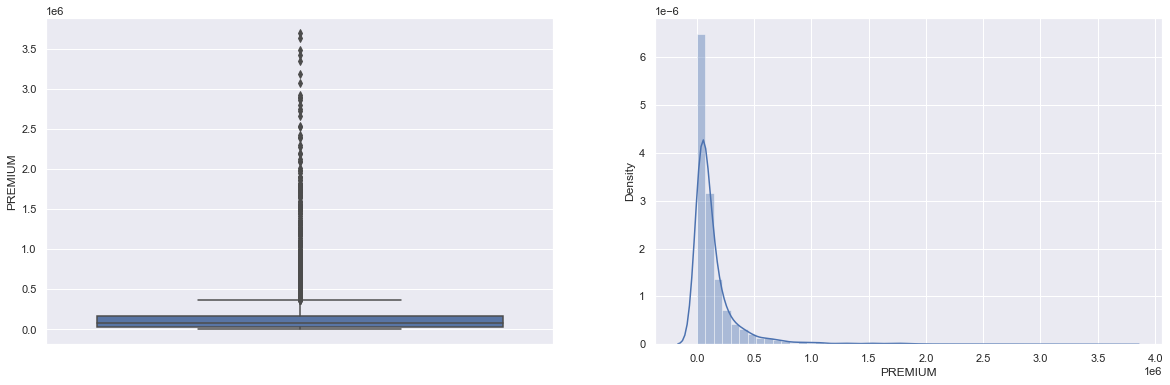

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(20,6))
sns.boxplot(data=pm, y= 'PREMIUM', ax=axs[0] )
sns.distplot(pm.PREMIUM, ax=axs[1] )

<AxesSubplot:ylabel='PREMIUM'>

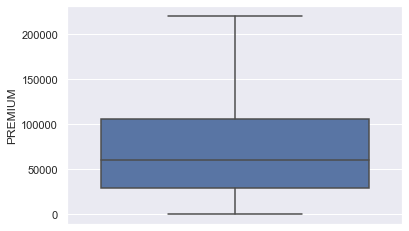

In [12]:
sns.boxplot(data=pm[pm.PREMIUM < 220000], y= 'PREMIUM')

In [13]:
# create a new dimension by degree of loss
cut = [0, 60000, 220000, 1000000000]
labels = ['low','middle','high']
pm["premium_level"] = pd.cut(pm.PREMIUM, cut, labels=labels)
pm.head()

FACUL_NUM  DIVISION_NUM    TAG      SEGMENT_LOB UF_STATUS  CT_STATUS  \
0  02F062851             4  Bound  Ppty Non Energy    Active  Finalized   
1  11F008861             1  Bound  Ppty Non Energy    Active  Finalized   
2  02F062851             4  Bound  Ppty Non Energy    Active  Finalized   
3  FA0020462             1  Bound  Ppty Non Energy    Active  Finalized   
4  02F062851             4  Bound  Ppty Non Energy    Active  Finalized   

   UWYEAR  CT_PERIOD     MARKET MAIN_COUNTRY       SUBSECTOR  \
0    2019         12  ARGENTINA    Argentina  MINING COMPANY   
1    2017         12     CANADA    Argentina  MINING COMPANY   
2    2018         12  ARGENTINA    Argentina  MINING COMPANY   
3    2018         12     CANADA    Argentina  MINING COMPANY   
4    2017         12  ARGENTINA    Argentina  MINING COMPANY   

           MAINOCCUPANCY      BUSINESSUNIT UWCENTER COVERAGE        PARTTYPE  \
0  Precious Metals Mines  BS Energy Mining     EMEA    PD,BI  Excess of Loss   
1  Precious Metals Mines  BS Energy Mining   CANADA    PD,BI     Quota-Share   
2  Precious Metals Mines  BS Energy Mining     EMEA    PD,BI  Excess of Loss   
3  Precious Metals Mines  BS Energy Mining   CANADA    PD,BI     Quota-Share   
4  Precious Metals Mines  BS Energy Mining     EMEA    PD,BI  Excess of Loss   

     GUARANTEE  MAIN_PRICING_CATEG MAIN_PRICING_SUBCATEG         BI_TYPE  \
0  Unspecified  Mining - Hard Rock              Standard  Loss of profit   
1  Unspecified  Mining - Hard Rock              Standard  Loss of profit   
2  Unspecified  Mining - Hard Rock              Standard  Loss of profit   
3  Unspecified  Mining - Hard Rock              Standard  Loss of profit   
4  Unspecified  Mining - Hard Rock              Standard  Loss of profit   

   BI_PERIOD  INSUREDVALUEPD  INSUREDVALUEBI  TOTALINSUREDVALUE  NBLOCS  OIL  \
0       12.0        4.33e+08        1.81e+08           6.14e+08       1  0.0   
1       12.0        5.37e+08        1.64e+08           7.01e+08       3  0.0   
2       12.0        4.18e+08        2.40e+08           6.58e+08       1  0.0   
3       12.0        4.90e+08        2.27e+08           7.17e+08       3  0.0   
4       12.0        4.53e+08        2.53e+08           7.06e+08       1  0.0   

      LIMIT  ATTACHMENT  SCOR_SHARE    PREMIUM  MODELED_CAT_EXPLOSS  \
0  3.59e+08    6.60e+06        0.10   51556.79                  0.0   
1  1.86e+08    0.00e+00        0.07  101618.14                  0.0   
2  3.43e+08    6.32e+06        0.10   45815.49                  0.0   
3  1.68e+08    0.00e+00        0.03   35547.13                  0.0   
4  3.79e+08    6.97e+06        0.10   69669.24                  0.0   

   DISCOUNTS  DEDUCTION  EXT_EXPENSE   WORDING QUALITY_RISK_MGT ASSET_QUALITY  \
0        0.0       0.09         0.09  Standard          Average       Average   
1        0.0       0.12         0.12  Standard          Average       Average   
2        0.0       0.13         0.13  Standard          Average       Average   
3        0.0       0.11         0.11  Standard          Average       Average   
4        0.0       0.14         0.14  Standard          Average       Average   

  BI_MITIGATION MB_QUALITY ORIGCCY  TXCHANGE  FXRATEUSD   TOP_MPL  TOP_FMLS  \
0       Average        NaN     USD      0.88        1.0  1.99e+08       NaN   
1       Average        NaN     USD      0.93        1.0  1.86e+08       NaN   
2       Average        NaN     USD      0.84        1.0  2.57e+08       NaN   
3       Average        NaN     USD      0.84        1.0  2.29e+08       NaN   
4       Average        NaN     USD      0.93        1.0  2.35e+08       NaN   

   pd_bi   pd    bi  inception_year  inception_month  inception_duration  \
0    NaN  0.9  30.0            2019                4                 690   
1    NaN  0.5  30.0            2017                4                1391   
2    NaN  0.8  30.0            2018                3                1086   
3    NaN  0.4  30.0            2018                6   

In [14]:
pm_uw = pm.merge(uw, left_on=['FACUL_NUM','UWYEAR'], right_on=['FACUL_NUM','UWYEAR'], how='left')

In [15]:
pm_uw.head()

FACUL_NUM  DIVISION_NUM    TAG      SEGMENT_LOB UF_STATUS  CT_STATUS  \
0  02F062851             4  Bound  Ppty Non Energy    Active  Finalized   
1  11F008861             1  Bound  Ppty Non Energy    Active  Finalized   
2  02F062851             4  Bound  Ppty Non Energy    Active  Finalized   
3  FA0020462             1  Bound  Ppty Non Energy    Active  Finalized   
4  02F062851             4  Bound  Ppty Non Energy    Active  Finalized   

   UWYEAR  CT_PERIOD     MARKET MAIN_COUNTRY       SUBSECTOR  \
0    2019         12  ARGENTINA    Argentina  MINING COMPANY   
1    2017         12     CANADA    Argentina  MINING COMPANY   
2    2018         12  ARGENTINA    Argentina  MINING COMPANY   
3    2018         12     CANADA    Argentina  MINING COMPANY   
4    2017         12  ARGENTINA    Argentina  MINING COMPANY   

           MAINOCCUPANCY      BUSINESSUNIT UWCENTER COVERAGE        PARTTYPE  \
0  Precious Metals Mines  BS Energy Mining     EMEA    PD,BI  Excess of Loss   
1  Precious Metals Mines  BS Energy Mining   CANADA    PD,BI     Quota-Share   
2  Precious Metals Mines  BS Energy Mining     EMEA    PD,BI  Excess of Loss   
3  Precious Metals Mines  BS Energy Mining   CANADA    PD,BI     Quota-Share   
4  Precious Metals Mines  BS Energy Mining     EMEA    PD,BI  Excess of Loss   

     GUARANTEE  MAIN_PRICING_CATEG MAIN_PRICING_SUBCATEG         BI_TYPE  \
0  Unspecified  Mining - Hard Rock              Standard  Loss of profit   
1  Unspecified  Mining - Hard Rock              Standard  Loss of profit   
2  Unspecified  Mining - Hard Rock              Standard  Loss of profit   
3  Unspecified  Mining - Hard Rock              Standard  Loss of profit   
4  Unspecified  Mining - Hard Rock              Standard  Loss of profit   

   BI_PERIOD  INSUREDVALUEPD  INSUREDVALUEBI  TOTALINSUREDVALUE  NBLOCS  OIL  \
0       12.0        4.33e+08        1.81e+08           6.14e+08       1  0.0   
1       12.0        5.37e+08        1.64e+08           7.01e+08       3  0.0   
2       12.0        4.18e+08        2.40e+08           6.58e+08       1  0.0   
3       12.0        4.90e+08        2.27e+08           7.17e+08       3  0.0   
4       12.0        4.53e+08        2.53e+08           7.06e+08       1  0.0   

      LIMIT  ATTACHMENT  SCOR_SHARE    PREMIUM  MODELED_CAT_EXPLOSS  \
0  3.59e+08    6.60e+06        0.10   51556.79                  0.0   
1  1.86e+08    0.00e+00        0.07  101618.14                  0.0   
2  3.43e+08    6.32e+06        0.10   45815.49                  0.0   
3  1.68e+08    0.00e+00        0.03   35547.13                  0.0   
4  3.79e+08    6.97e+06        0.10   69669.24                  0.0   

   DISCOUNTS  DEDUCTION  EXT_EXPENSE   WORDING QUALITY_RISK_MGT ASSET_QUALITY  \
0        0.0       0.09         0.09  Standard          Average       Average   
1        0.0       0.12         0.12  Standard          Average       Average   
2        0.0       0.13         0.13  Standard          Average       Average   
3        0.0       0.11         0.11  Standard          Average       Average   
4        0.0       0.14         0.14  Standard          Average       Average   

  BI_MITIGATION MB_QUALITY ORIGCCY  TXCHANGE  FXRATEUSD   TOP_MPL  TOP_FMLS  \
0       Average        NaN     USD      0.88        1.0  1.99e+08       NaN   
1       Average        NaN     USD      0.93        1.0  1.86e+08       NaN   
2       Average        NaN     USD      0.84        1.0  2.57e+08       NaN   
3       Average        NaN     USD      0.84        1.0  2.29e+08       NaN   
4       Average        NaN     USD      0.93        1.0  2.35e+08       NaN   

   pd_bi   pd    bi  inception_year  inception_month  inception_duration  \
0    NaN  0.9  30.0            2019                4                 690   
1    NaN  0.5  30.0            2017                4                1391   
2    NaN  0.8  30.0            2018                3                1086   
3    NaN  0.4  30.0            2018                6   

In [24]:
ex = pd.read_csv('../01_Data/01_Raw/exposure_data_v2.csv')
ex.head()

FACUL_NUM  YEAR  ORDER_NUM  ENDOR_NUM  DIVISION_NUM COUNTRY   STATE COUNTY  \
0  FA0030265  2017          1          1             1      US  USA-UT  UT-39   
1  FA0030265  2017          1          1             1      US  USA-UT  UT-35   
2  FA0030265  2017          1          1             1      US  USA-UT  UT-49   
3  FA0030265  2017          1          1             1      US  USA-UT    NaN   
4  FA0030265  2017          1          1             2      US  USA-UT  UT-43   

        CITY_NAME ZIP_CD  LATITUDE  LONGITUDE  ACCURACY_VALIDATE  \
0           Manti  84642      39.3     -111.6                  1   
1  Salt Lake City  84109      40.7     -111.8                  1   
2   American Fork  84003      40.4     -111.8                  1   
3             NaN    NaN      40.3     -111.9                  0   
4           Kamas  84036      40.7     -111.2                  1   

  EXTERNAL_REFERENCE  GEO_CD OCCUPANCY_SCHEMA OCCUPANCY_CD OCCUPANCY_SOURCE  \
0                510   UT-39            ACORD    COMPUB999              NaN   
1               7908   UT-35            ACORD    COMPUB999              NaN   
2               2034   UT-49            ACORD    COMPUB999           WHSHOP   
3                NaN  USA-UT            ACORD    COMPUB999              NaN   
4               8980   UT-43            ACORD    COMPUB999              NaN   

  CONSTRUCTION_SCHEMA CONSTRUCTION_CD  \
0               ACORD          UNSUNS   
1               ACORD          UNSUNS   
2               ACORD          STLFRA   
3               ACORD          UNSUNS   
4               ACORD          UNSUNS   

                                 CONSTRUCTION_SOURCE  YR_BLT  NO_OF_STRY  \
0                                                NaN     NaN         NaN   
1                                                NaN     NaN         NaN   
2  Fireproofed structural steel frames w/ reinfor...     NaN         NaN   
3                                                NaN     NaN         NaN   
4                                                NaN     NaN         NaN   

   NO_OF_BLDG SITE_CCY_CD  IV_BUILDING  IV_CONTENT     IV_PD     IV_BI  \
0         NaN         USD     2.01e+06    0.00e+00  2.01e+06  31980.22   
1         NaN         USD     1.80e+06    1.82e+05  1.98e+06  31571.92   
2         NaN         USD     9.07e+05    1.06e+06  1.97e+06  31343.37   
3         NaN         USD     0.00e+00    1.93e+06  1.93e+06  30748.62   
4         NaN         USD     1.70e+06    1.70e+05  1.87e+06  29778.59   

   BI_DECLARATION_PERIOD       TIV FOR_INTEREST BI_TYPE  INTEREST_DECLARATION  \
0                   12.0  2.04e+06           FI     NaN                   1.0   
1                   12.0  2.01e+06           FI     NaN                   1.0   
2                   12.0  2.00e+06           FI     NaN                   1.0   
3                   12.0  1.96e+06           FI     NaN                   1.0   
4                   12.0  1.90e+06           FI     NaN                   1.0   

     MPL_PD  MPL_PD_PERCEN MPL_PD_TYPE    MPL_BI  MPL_BI_PERCEN MPL_BI_TYPE  \
0       NaN            NaN         NaN       NaN            NaN         NaN   
1       NaN            NaN         NaN       NaN            NaN         NaN   
2  1.48e+06           75.0  Percentage  23507.53           75.0  Percentage   
3  1.45e+06           75.0  Percentage  23061.46           75.0  Percentage   
4       NaN            NaN         NaN       NaN            NaN         NaN   

   FMLS_PD  FMLS_PD_PERCEN FMLS_PD_TYPE  FMLS_BI  FMLS_BI_PERCEN FMLS_BI_TYPE  \
0      NaN             NaN          NaN      NaN             NaN          NaN   
1      NaN             NaN          NaN      NaN             NaN          NaN   
2      NaN             NaN          NaN      NaN             NaN          NaN   
3      NaN             NaN          NaN      NaN             NaN          NaN   
4      NaN             NaN          NaN      NaN             NaN          NaN   

  COVERAGE_TYPE          CATEGORY 

In [ ]:
ex.

In [31]:
ex.CATEGORY.unique()

array(['Public buildings', 'Commercial buildings',
       'Telecommunications & Media', 'Other Onshore', 'Infrastructure',
       'Warehouse', 'Leisure industry',
       'Midstream - Transportation/Storage', 'Food producers', 'Power',
       'Automotive & Parts', 'Gas Processing', 'Aerospace & Defence',
       'Rubber & Plastic Manufacturing', 'High Tech Industries',
       'Metal Works', 'Chemicals', 'Transportation & Logistics',
       'Pulp & paper', 'Metallurgy', 'Other categories',
       'Waste Treatment', 'Water Treatment', 'Printing industry',
       'Petrochemical', 'Building materials',
       'Pharmaceuticals & fine chemicals', 0, 'Specialty chemicals',
       'Crude Processing - Refining', 'Mining - Bulk commodities',
       'Mining - Hard Rock', 'Mechanical industries',
       'Beverage producers', 'Tobacco', 'Glass/ Ceramic/Others',
       'Wood industry', 'Textile industry', 'Mining - Other',
       'Mining - Underground coal', 'Railway manufacturing industry'],
      dt

In [25]:
ex=ex.fillna(0)

In [26]:
ex = ex[['FACUL_NUM', 'YEAR', 'DIVISION_NUM', 'ZIP_CD','ACCURACY_VALIDATE', 'YR_BLT',
       'NO_OF_STRY', 'NO_OF_BLDG', 'IV_BUILDING', 'IV_CONTENT', 'IV_PD',
       'IV_BI', 'TIV', 'INTEREST_DECLARATION', 'MPL_PD', 'MPL_PD_PERCEN',
       'MPL_BI', 'MPL_BI_PERCEN', 'FMLS_PD', 'FMLS_PD_PERCEN', 'FMLS_BI',
       'FMLS_BI_PERCEN','CATEGORY', 'LARGEST_UNIT_CAPACITY']]

In [28]:
# sort value in ascending order and drop duplicate
ex.sort_values(by='MPL_PD', inplace=True, na_position='first')
ex.drop_duplicates(inplace=True, keep='last')

In [32]:
ex_g = ex.groupby(['FACUL_NUM','YEAR','DIVISION_NUM']).agg({
                                    'ZIP_CD':pd.Series.nunique,
                                      'ACCURACY_VALIDATE':'mean',
                                      'YR_BLT':'mean',
                                      'NO_OF_STRY':'sum',
                                      'NO_OF_BLDG':'sum',
                                      'IV_BUILDING':'sum',
                                      'IV_CONTENT':'sum',
                                      'IV_PD':'sum',
                                      'IV_BI':'sum',
                                      'TIV':'sum',
                                      'INTEREST_DECLARATION':'sum',
                                     'MPL_PD':'sum',
                                     'MPL_PD_PERCEN':'mean',
                                     'MPL_BI':'mean',
                                     'MPL_BI_PERCEN':'mean',
                                     'FMLS_PD':'sum',
                                     'FMLS_PD_PERCEN':'mean',
                                     'FMLS_BI':'sum',
                                     'FMLS_BI_PERCEN':'mean',
                                     'CATEGORY':pd.Series.nunique,
                                     'LARGEST_UNIT_CAPACITY':'sum'}).reset_index().rename(columns={'ZIP_CD':'nb_location',
                                                                                                  'CATEGORY':'nb_category'})
                                      

In [20]:
ex_g.head()

FACUL_NUM  YEAR  DIVISION_NUM  nb_location  ACCURACY_VALIDATE  YR_BLT  \
0  01F009143  2018             1            0                1.0     NaN   
1  01F015880  2017             1           10                1.0     0.0   
2  01F015880  2018             1           10                1.0     0.0   
3  01F015880  2018             2           10                1.0     0.0   
4  01F016191  2017             1           19                1.0     NaN   

   NO_OF_STRY  NO_OF_BLDG  IV_BUILDING  IV_CONTENT     IV_PD     IV_BI  \
0         0.0         0.0     4.21e+08    1.33e+09  1.76e+09  1.71e+08   
1         0.0         0.0     3.71e+08    8.24e+08  1.20e+09  3.55e+08   
2         0.0         0.0     3.71e+08    8.24e+08  1.20e+09  3.55e+08   
3         0.0         0.0     1.86e+08    4.12e+08  5.98e+08  1.77e+08   
4         0.0         0.0     5.19e+09    2.37e+10  2.89e+10  4.49e+09   

        TIV  INTEREST_DECLARATION    MPL_PD  MPL_PD_PERCEN    MPL_BI  \
0  1.93e+09                   2.0  3.75e+08          42.73  1.28e+08   
1  1.23e+09                  22.0  4.57e+08          75.69  1.04e+07   
2  1.23e+09                  22.0  4.57e+08          75.69  1.04e+07   
3  6.16e+08                  11.0  0.00e+00            NaN       NaN   
4  3.28e+10                  46.0  3.46e+09          27.26  3.15e+08   

   MPL_BI_PERCEN  FMLS_PD  FMLS_PD_PERCEN  FMLS_BI  FMLS_BI_PERCEN  \
0         100.00      0.0             NaN      0.0             NaN   
1          47.28      0.0             NaN      0.0             NaN   
2          41.82      0.0             NaN      0.0             NaN   
3            NaN      0.0             NaN      0.0             NaN   
4         141.37      0.0             NaN      0.0             NaN   

   nb_category  LARGEST_UNIT_CAPACITY  
0            1                    0.0  
1            3                    0.0  
2            3                    0.0  
3            3                    0.0  
4            2                    0.0

In [33]:
pm_uw['UWYEAR']=pd.to_datetime(pm_uw.UWYEAR)
ex_g['YEAR'] = pd.to_datetime(ex_g.YEAR)

In [34]:
df = pm_uw.merge(ex_g, left_on=['FACUL_NUM','UWYEAR','DIVISION_NUM'], right_on=['FACUL_NUM','YEAR','DIVISION_NUM'], how='left')
df.head()

FACUL_NUM  DIVISION_NUM    TAG      SEGMENT_LOB UF_STATUS  CT_STATUS  \
0  02F062851             4  Bound  Ppty Non Energy    Active  Finalized   
1  11F008861             1  Bound  Ppty Non Energy    Active  Finalized   
2  02F062851             4  Bound  Ppty Non Energy    Active  Finalized   
3  FA0020462             1  Bound  Ppty Non Energy    Active  Finalized   
4  02F062851             4  Bound  Ppty Non Energy    Active  Finalized   

                         UWYEAR  CT_PERIOD     MARKET MAIN_COUNTRY  \
0 1970-01-01 00:00:00.000002019         12  ARGENTINA    Argentina   
1 1970-01-01 00:00:00.000002017         12     CANADA    Argentina   
2 1970-01-01 00:00:00.000002018         12  ARGENTINA    Argentina   
3 1970-01-01 00:00:00.000002018         12     CANADA    Argentina   
4 1970-01-01 00:00:00.000002017         12  ARGENTINA    Argentina   

        SUBSECTOR          MAINOCCUPANCY      BUSINESSUNIT UWCENTER COVERAGE  \
0  MINING COMPANY  Precious Metals Mines  BS Energy Mining     EMEA    PD,BI   
1  MINING COMPANY  Precious Metals Mines  BS Energy Mining   CANADA    PD,BI   
2  MINING COMPANY  Precious Metals Mines  BS Energy Mining     EMEA    PD,BI   
3  MINING COMPANY  Precious Metals Mines  BS Energy Mining   CANADA    PD,BI   
4  MINING COMPANY  Precious Metals Mines  BS Energy Mining     EMEA    PD,BI   

         PARTTYPE    GUARANTEE  MAIN_PRICING_CATEG MAIN_PRICING_SUBCATEG  \
0  Excess of Loss  Unspecified  Mining - Hard Rock              Standard   
1     Quota-Share  Unspecified  Mining - Hard Rock              Standard   
2  Excess of Loss  Unspecified  Mining - Hard Rock              Standard   
3     Quota-Share  Unspecified  Mining - Hard Rock              Standard   
4  Excess of Loss  Unspecified  Mining - Hard Rock              Standard   

          BI_TYPE  BI_PERIOD  INSUREDVALUEPD  INSUREDVALUEBI  \
0  Loss of profit       12.0        4.33e+08        1.81e+08   
1  Loss of profit       12.0        5.37e+08        1.64e+08   
2  Loss of profit       12.0        4.18e+08        2.40e+08   
3  Loss of profit       12.0        4.90e+08        2.27e+08   
4  Loss of profit       12.0        4.53e+08        2.53e+08   

   TOTALINSUREDVALUE  NBLOCS  OIL     LIMIT  ATTACHMENT  SCOR_SHARE  \
0           6.14e+08       1  0.0  3.59e+08    6.60e+06        0.10   
1           7.01e+08       3  0.0  1.86e+08    0.00e+00        0.07   
2           6.58e+08       1  0.0  3.43e+08    6.32e+06        0.10   
3           7.17e+08       3  0.0  1.68e+08    0.00e+00        0.03   
4           7.06e+08       1  0.0  3.79e+08    6.97e+06        0.10   

     PREMIUM  MODELED_CAT_EXPLOSS  DISCOUNTS  DEDUCTION  EXT_EXPENSE  \
0   51556.79                  0.0        0.0       0.09         0.09   
1  101618.14                  0.0        0.0       0.12         0.12   
2   45815.49                  0.0        0.0       0.13         0.13   
3   35547.13                  0.0        0.0       0.11         0.11   
4   69669.24                  0.0        0.0       0.14         0.14   

    WORDING QUALITY_RISK_MGT ASSET_QUALITY BI_MITIGATION MB_QUALITY ORIGCCY  \
0  Standard          Average       Average       Average        NaN     USD   
1  Standard          Average       Average       Average        NaN     USD   
2  Standard          Average       Average       Average        NaN     USD   
3  Standard          Average       Average       Average        NaN     USD   
4  Standard          Average       Average       Average        NaN     USD   

   TXCHANGE  FXRATEUSD   TOP_MPL  TOP_FMLS  pd_bi   pd    bi  inception_year  \
0      0.88        1.0  1.99e+08       NaN    NaN  0.9  30.0            2019   
1      0.93        1.0  1.86e+08       NaN    NaN  0.5  30.0            2017   
2      0.84        1.0  2.57e+08       NaN    NaN  0.8  30.0            2018   
3      0.84        1.0  2.29e+08       NaN    NaN  0.4  30.0            2018   
4      0.93        1.0  2.35e+08       NaN    NaN  0.9  30.0            2

In [35]:
df.to_excel("../01_Data/02_Processed/processed_v3.xlsx", index=False)

In [36]:
tmp = df[(df.loss_level=='zero')|(df.loss_level=='mild')]
g1 = alt.Chart(tmp, title='zero').mark_bar().encode(
    alt.X('MAINOCCUPANCY:O'), alt.Y('count()',stack='normalize'), color='loss_level'
).properties(width=1200,height=200)
g1

alt.Chart(...)

- Accounts that had zero UW ratio has higher energy property

Text(0.5, 1.0, 'High loss accounts')

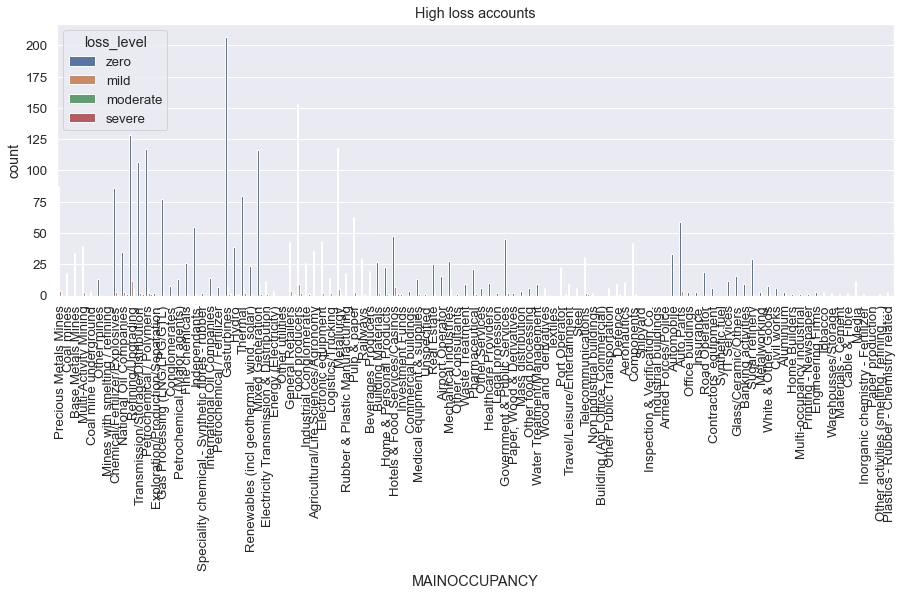

In [37]:
sns.set(font_scale=1.2)
plt.figure(figsize=(15,5))
ax1 = sns.countplot(x='MAINOCCUPANCY', hue='loss_level',data=df)
plt.xticks(rotation=90)
ax1.set_title('High loss accounts')

In [ ]:
sns.set(font_scale=1.1)
plt.figure(figsize=(20,5))
ax1 = sns.countplot(df[df.loss_level=='severe']['MARKET'])
plt.xticks(rotation=90)
ax1.set_title('High loss accounts')

In [ ]:
sns.set(font_scale=1.1)
plt.figure(figsize=(20,5))
ax1 = sns.countplot(df[df.loss_level=='zero']['MARKET'])
plt.xticks(rotation=90)
ax1.set_title('zero loss accounts')

In [ ]:
sns.set(font_scale=1.1)
plt.figure(figsize=(20,5))
ax1 = sns.countplot(df[df.loss_level=='zero']['MAINOCCUPANCY'])
plt.xticks(rotation=90)
ax1.set_title('High loss accounts')

In [38]:
qc = df[df.MAIN_COUNTRY.isin(df.MAIN_COUNTRY.value_counts()[df.MAIN_COUNTRY.value_counts()>=5].index)].MAIN_COUNTRY
qi = df[df.SUBSECTOR.isin(df.SUBSECTOR.value_counts()[df.SUBSECTOR.value_counts()>=5].index)].SUBSECTOR


In [39]:
qc.drop_duplicates(inplace=True)
qc

0             Argentina
8             Australia
83               Brazil
97               Canada
153               Chile
             ...       
1991          Nicaragua
2104        Puerto Rico
2152          Sri Lanka
3302     Czech Republic
3941    Myanmar (Burma)
Name: MAIN_COUNTRY, Length: 77, dtype: object

In [40]:
qi.drop_duplicates(inplace=True)
qi

0                      MINING COMPANY
364          ONSHORE CO & CHEMICAL CO
373        INTEGRATED CO,CONGLOMERATE
392            OFFSHORE (E&P) COMPANY
463                    CONSUMER GOODS
464                  OTHER INDUSTRIES
575        CONSTRUCTION & ENGINEERING
584     CORPORATE PROPERTY & CASUALTY
622        ENVIRONMENTAL SERV. & IND.
650                  HEAVY INDUSTRIES
693                SECTOR UNSPECIFIED
770           POWER & UTILITY COMPANY
810        ENERGY & NATURAL RESOURCES
1153            HIGH TECH. INDUSTRIES
1380       TRANSPORTATION & LOGISTICS
2438                   OTHER SERVICES
2559       AGRICULTURAL/LIFE SCIENCES
2609           FINANCIAL INSTITUTIONS
2611                       HEALTHCARE
2693                CONSUMER SERVICES
2798       TELECOMMUNICATIONS & MEDIA
2826              AEROSPACE & DEFENCE
2904            PROFESSIONAL SERVICES
3079               AUTOMOTIVE & PARTS
Name: SUBSECTOR, dtype: object

In [41]:
dfqi = df[df.SUBSECTOR.isin(qi)]
dfqi = dfqi[['PREMIUM','SUBSECTOR']]
dfqi_ = pd.get_dummies(dfqi)

In [43]:
dfqc = df[df.MAIN_COUNTRY.isin(qc)]
dfqc = dfqc[['PREMIUM','MAIN_COUNTRY']]
dfqc_ = pd.get_dummies(dfqc)

In [44]:
df.MAIN_PRICING_SUBCATEG.nunique()

166

In [45]:
corr_qi = pd.DataFrame(dfqi_[dfqi_.columns[0:]].corr()['PREMIUM'][:]).rename(columns = {"PREMIUM":"Correlation to Premium"})
cat_pos = corr_qi.sort_values(by='Correlation to Premium', axis=0, ascending=False).head(25).reset_index()
cat_pos.index += 1
cat_pos.style.background_gradient(cmap="GnBu")

In [46]:
corr_qi = pd.DataFrame(dfqi_[dfqi_.columns[0:]].corr()['PREMIUM'][:]).rename(columns = {"PREMIUM":"Correlation to Premium"})
cat_pos = corr_qi.sort_values(by='Correlation to Premium', axis=0).head(25).reset_index()
cat_pos.index += 1
cat_pos.style.background_gradient(cmap="GnBu")

In [47]:
corr_qc = pd.DataFrame(dfqc_[dfqc_.columns[0:]].corr()['PREMIUM'][:]).rename(columns = {"PREMIUM":"Correlation to Premium"})
cat_pos = corr_qc.sort_values(by='Correlation to Premium', axis=0, ascending=False).head(25).reset_index()
cat_pos.index += 1
cat_pos.style.background_gradient(cmap="GnBu")

In [48]:
neg = corr_qc.sort_values(by='Correlation to Premium', axis=0).head(50).reset_index()
neg.index += 1
neg.style.background_gradient(cmap="GnBu")

In [ ]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(dfmw.UW_RATIO_2020, dfmw.MAIN_COUNTRY)
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

In [ ]:
df2.MAIN_COUNTRY.nunique()

In [ ]:
df2c = df2[['PREMIUM','MAIN_COUNTRY']]
df2c = get_dummies()
df2c.shape

In [ ]:
corr_cat_dummy = pd.DataFrame(cat_dummy[cat_dummy.columns[0:]].corr()['PREMIUM'][:]).rename(columns = {"PREMIUM":"Correlation to Premium"})
cat_pos = corr_cat_dummy.sort_values(by='Correlation to Premium', axis=0, ascending=False).head(11).reset_index()
cat_pos.index += 1
cat_pos.style.background_gradient(cmap="GnBu")

In [ ]:
corr_corr = df.corr()

mask = np.zeros_like(corr_corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (15, 11))

sns.heatmap(corr_corr, mask = mask, square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

In [ ]:
tmp = df2[['cat','UWYEAR','MAIN_COUNTRY','FACUL_NUM','UW_RATIO_2020']].groupby(['cat','UWYEAR','MAIN_COUNTRY']).agg({'FACUL_NUM':'count',
                                                                        'UW_RATIO_2020':'mean'}).reset_index().rename(columns={'FACUL_NUM':'count'})
tmp

In [ ]:
tmp2 = df2[['cat','UWYEAR','MAIN_PRICING_CATEG','FACUL_NUM','UW_RATIO_2020']].groupby(['cat','UWYEAR','MAIN_PRICING_CATEG']).agg({'FACUL_NUM':'count',
                                                                       'UW_RATIO_2020':'mean'}).reset_index().rename(columns={'FACUL_NUM':'count'})
tmp2

In [ ]:
pm.MAIN_COUNTRY.value_counts().tail(50)

In [ ]:
tmp4 = df2[['MAIN_COUNTRY','PREMIUM']].groupby(['MAIN_COUNTRY']).max().reset_index()

In [ ]:
alt.Chart(tmp4, title='2017').mark_bar().encode(
    alt.X('MAIN_COUNTRY'), alt.Y('PREMIUM')
).properties(width=1500,height=200)

In [ ]:
g1 = alt.Chart(tmp[tmp.UWYEAR == 2017], title='2017').mark_bar().encode(
    alt.X('MAIN_COUNTRY:O'), alt.Y('count',stack='normalize'), color='cat'
).properties(width=1500,height=200)
g2 = alt.Chart(tmp[tmp.UWYEAR == 2018], title='2018').mark_bar().encode(
    alt.X('MAIN_COUNTRY:O'), alt.Y('count',stack='normalize'), color='cat'
).properties(width=1500,height=200)
g3 = alt.Chart(tmp[tmp.UWYEAR == 2019], title='2019').mark_bar().encode(
    alt.X('MAIN_COUNTRY:O'), alt.Y('count',stack='normalize'), color='cat'
).properties(width=1500,height=200)
g4 = alt.Chart(tmp[tmp.UWYEAR == 2020], title='2020').mark_bar().encode(
    alt.X('MAIN_COUNTRY:O'), alt.Y('count',stack='normalize'), color='cat'
).properties(width=1500,height=200)
g1

- In 2017 Brazil, India, Indonesia, Mexico, Philippines, Saudi Arabia, US and Venezuela was reratively high loss

In [ ]:
g2

- In 2018, Canada, Malaysia, Russia, US had high loss

In [ ]:
g3

- In 2019, France, Jordan, Mexico, South Korea, US had high loss

In [ ]:
g4

In [ ]:
alt.Chart(tmp2[tmp2.UWYEAR == 2017], title='2017').mark_bar().encode(
    alt.X('MAIN_PRICING_CATEG:O'), alt.Y('count'), color='cat'
).properties(width=800,height=300)

In [ ]:
alt.Chart(tmp2[tmp2.UWYEAR == 2018], title='2018').mark_bar().encode(
    alt.X('MAIN_PRICING_CATEG:O'), alt.Y('count'), color='cat'
).properties(width=800,height=300)

In [ ]:
alt.Chart(tmp2[tmp2.UWYEAR == 2019], title='2019').mark_bar().encode(
    alt.X('MAIN_PRICING_CATEG:O'), alt.Y('count'), color='cat'
).properties(width=800,height=300)

In [ ]:
CONSTRUCTION_CD	YR_BLT	NO_OF_STRY	NO_OF_BLDG	IV_BUILDING	
IV_CONTENT	IV_PD	IV_BI	BI_DECLARATION_PERIOD	TIV	FOR_INTEREST	BI_TYPE	
INTEREST_DECLARATION	MPL_PD	MPL_PD_PERCEN	MPL_PD_TYPE	MPL_BI	MPL_BI_PERCEN	
MPL_BI_TYPE	FMLS_PD	FMLS_PD_PERCEN	FMLS_PD_TYPE	
FMLS_BI	FMLS_BI_PERCEN	FMLS_BI_TYPE	COVERAGE_TYPE	CATEGORY	SUB_CATEGORY

In [ ]:
df.CATEGORY.unique()

In [ ]:
df['inception_year'], df['inception_month'] = df['INCEPTION'].dt.year, df['INCEPTION'].dt.month
df['inception_duration'], df['pricing_duration'] = datetime.now() - df['INCEPTION'], datetime.now() - df['PRICING_DATE']
df['inception_duration'], df['pricing_duration'] = df['inception_duration'].dt.days, df['pricing_duration'].dt.days

In [ ]:
exclude=['ORDER_NUM', 'COUNTY', 'CITY_NAME', 'ZIP_CD', 'LATITUDE','LONGITUDE','GEO_CD',
         'EXTERNAL_REFERENCE', 'LARGEST_UNIT_CAPACITY', 
         'COVERAGE_TYPE', 'BI_TYPE', 'OCCUPANCY_SCHEMA',
         'CONSTRUCTION_SCHEMA', 'FMLS_BI_TYPE','COVERAGE_TYPE','OP_STATUS']

In [ ]:
df_ = df.drop(exclude , axis=1)

In [ ]:
summary(df_)

In [ ]:
df['contract_year'] = df['FACUL_NUM'] + '_' + df['YEAR'].astype(str)
uw_ratio['contract_year'] = uw_ratio['FACUL_NUM'] + '_' + uw_ratio['UWYEAR'].astype(str)

In [ ]:
df2 = pd.merge(uw_ratio, df, on=['contract_year', 'contract_year'], how='inner', suffixes=('', '_'))

In [ ]:
print(df2.shape)
df2.head()

## First analyse the contract with high under write ratio

In [ ]:
df2_sorted = df2.sort_values(by='UW_RATIO_2020', axis=0, ascending=False)
df2_sorted.head()

In [ ]:
df2_sorted.shape

In [ ]:
top_100 = df2_sorted.iloc[0:100,:]

In [ ]:
bottom_100 = df2_sorted.iloc[4979307:4979407,:]

In [ ]:
bottom_100.shape

In [ ]:
top = round(top_100.describe())[1:2].values
bottom = round(bottom_100.describe())[1:2].values
conc = np.concatenate((top, bottom), axis=0)
compare = pd.DataFrame(conc, columns = top_100.describe().columns)
compare = compare.transpose().rename(columns={0:'top_100', 1:'bottom_100'})
compare.reset_index()

- 'IV_PD', 'IV_CONTENT', 'MPL_PD', 'MPL_PD_PERCEN', 'MPL_BI', 'FMLS_PD', 'FMLS_BI_PERCEN' are higher for bottom 100
- 'IV_BI' and 'FMLS_BI' are higher for top 100

In [ ]:
top_100['top_bottom'] = 'top_100'
bottom_100['top_bottom'] = 'bottom_100'
con = pd.concat([top_100, bottom_100])

In [ ]:
ax = plt.figure(figsize=(15,5))
g = sns.countplot(data=con, x='COUNTRY', hue='top_bottom')
plt.xticks(rotation=45)

In [ ]:
ax = plt.figure(figsize=(15,5))
g = sns.countplot(data=con, x='GEO_CD', hue='top_bottom')
plt.xticks(rotation=45)

In [ ]:
num_cols = df2_sorted._get_numeric_data().columns

In [ ]:
cat = df2_sorted.drop(num_cols, axis=1)

In [ ]:
cat = pd.concat([cat, df2_sorted.UW_RATIO_2020], axis=1)

In [ ]:
FACUL_NUM_x, FACUL_NUM_y, STATE, CITY_NAME, contract_year

In [ ]:
table = []
for col in cat.columns:
    table.append((col, cat[col].dtype, cat[col].nunique(), cat[col].isna().sum() ))
pd.DataFrame(table, columns=['Name', 'Type', 'Unique value', 'Missing Value'])

In [ ]:
cat.drop(['FACUL_NUM_x', 'SUB_CATEGORY'], axis=1, inplace=True)

In [ ]:
cat_dummy = pd.get_dummies(cat)

In [ ]:
corr_cat_dummy = pd.DataFrame(cat_dummy[cat_dummy.columns[0:]].corr()['UW_RATIO_2020'][:]).rename(columns = {"UW_RATIO_2020":"Correlation to UW_RATIO_2020"})
cat_pos = corr_cat_dummy.sort_values(by='Correlation to UW_RATIO_2020', axis=0, ascending=False).head(20).reset_index()
cat_pos.index += 1
cat_pos.style.background_gradient(cmap="GnBu")

In [ ]:
sys.argv